In [5]:
!pip install transformers torch torchvision pandas pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [4]:
import zipfile
import os

# Define paths
zip_path = "/mnt/data/compressed.zip"  # Replace with your uploaded file name
extract_path = "/mnt/data/"  # Choose an extraction location

# Create extraction folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ File extracted successfully to: {extract_path}")


BadZipFile: File is not a zip file

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import random
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define augmentations for over-sampling
import torchvision.transforms.v2 as T  # v2 handles tensors directly

augmentation_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])




In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize
    transforms.ConvertImageDtype(torch.float),  # Converts [0,255] → [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [7]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"



In [8]:
import cv2
import numpy as np
from torchvision.io import read_image



In [8]:
# Load labels file
labels = pd.read_excel("/mnt/data/labels..xlsx")  # Ensure correct path
image_to_family = dict(zip(labels["filename"], labels["family"]))

# Define the target number of samples per family
TARGET_SAMPLES_PER_FAMILY = 150

# Path where images are stored
image_folder = "/content/drive/MyDrive/IMAGES_final"

# List to store processed (tensor, label) pairs
tensor_dataset = []
processed_count = 0

# Adaptive balancing: Under-sample large families, Over-sample small families with augmentation
for family, count in labels["family"].value_counts().items():
    family_images = labels[labels["family"] == family]["filename"].tolist()

    if count > TARGET_SAMPLES_PER_FAMILY:
        # Under-sampling: Randomly select images
        selected_images = random.sample(family_images, TARGET_SAMPLES_PER_FAMILY)
    else:
        # Over-sampling: Apply augmentations to reach target count
        repeats = TARGET_SAMPLES_PER_FAMILY // count
        remaining = TARGET_SAMPLES_PER_FAMILY % count
        selected_images = family_images * repeats + random.sample(family_images, remaining)

    for img_name in selected_images:
        img_path = os.path.join(image_folder, img_name)
        try:

            image = read_image(img_path)
            if image.shape[0] == 1:  # Check if the image is grayscale
                 image = image.repeat(3, 1, 1)
            image = image.to(device)


            # Apply transformation (Resize + Normalize)
            transformed_image = transform(image)

            # Apply augmentation if the family is being oversampled
            if count < TARGET_SAMPLES_PER_FAMILY:
                augmented_image = augmentation_transforms(image)  # Apply augmentation
                transformed_image = transform(augmented_image)  # Reapply transformation

            # Append (tensor, label) pair to dataset
            tensor_dataset.append((transformed_image, family))
            processed_count += 1
            print(f"✅ Processed {processed_count}: {img_name} | Family: {family}")


        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Convert dataset to a PyTorch-compatible format and save
torch.save(tensor_dataset, "/mnt/data/balanced_dataset.pt")

print(f"✅ Balanced dataset saved with {len(tensor_dataset)} samples in PyTorch format!")



Streaming output truncated to the last 5000 lines.
✅ Processed 6102: Myidae_Sphenia_hatcheri_Poppe_673714-001.jpg | Family: Myidae
✅ Processed 6103: Myidae_Mya_truncata_Poppe_276917-001.jpg | Family: Myidae
✅ Processed 6104: Myidae_Mya_arenaria_Wales_001.jpg | Family: Myidae
✅ Processed 6105: Myidae_Cryptomya_africana_iDigBio_001-004.jpg | Family: Myidae
✅ Processed 6106: Myidae_Mya_arenaria_iDigBio_006.jpg | Family: Myidae
✅ Processed 6107: Myidae_Mya_truncata_Poppe_800661-002.jpg | Family: Myidae
✅ Processed 6108: Myidae_Mya_arenaria_GBIF_131-008.jpg | Family: Myidae
✅ Processed 6109: Myidae_Mya_truncata_Poppe_272793-001.jpg | Family: Myidae
✅ Processed 6110: Myidae_Mya_arenaria_Wales_006.jpg | Family: Myidae
✅ Processed 6111: Myidae_Sphenia_hatcheri_Poppe_673707-001.jpg | Family: Myidae
✅ Processed 6112: Myidae_Mya_arenaria_goe_1-009.jpg | Family: Myidae
✅ Processed 6113: Myidae_Mya_truncata_Wales_008.jpg | Family: Myidae
✅ Processed 6114: Myidae_Mya_truncata_fishercoll_6-002.jpg | 

In [3]:
import torch

# Load the saved dataset
balanced_dataset = torch.load("/mnt/data/balanced_dataset.pt")

# Example: Access the first (image, label) pair
tensor_image, label = balanced_dataset[0]

print(f"Image Tensor Shape: {tensor_image.shape}, Label: {label}")


<ipython-input-3-390cea2dec78>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  balanced_dataset = torch.load("/mnt/data/balanced_dataset.pt")


Image Tensor Shape: torch.Size([3, 224, 224]), Label: Pectinidae


In [ ]:
!zip -r /mnt/data/compressed.zip /mnt/data/balanced_dataset.pt

  adding: mnt/data/balanced_dataset.pt (deflated 79%)


In [10]:
!pip install timm torch torchvision







   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [9]:
import timm
import torch
from torchvision import transforms
from PIL import Image

# Load the SWAV model
model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
model.eval().to(device) # Set to evaluation mode
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1]) # Remove 'fc'
feature_extractor.eval() # Set to evaluation mode
# Print model architecture
print(model)
print(feature_extractor)


Using cache found in /root/.cache/torch/hub/facebookresearch_swav_main
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Step 1: Create a label mapping
unique_families = sorted(set([family for _, family in tensor_dataset]))  # Get unique labels
family_to_index = {family: idx for idx, family in enumerate(unique_families)}  # Map to index

# Print mapping for verification
print("Label Mapping (String to Index):", family_to_index)

# Step 2: Convert dataset labels to indices
indexed_dataset = [(image_tensor, family_to_index[family]) for image_tensor, family in tensor_dataset]

# Verify transformation
print(f"Original Label: {tensor_dataset[0][1]} -> Indexed Label: {indexed_dataset[0][1]}")

In [10]:
# Load preprocessed dataset (Tensor, Label) format
#balanced_dataset = torch.load("/mnt/data/balanced_dataset.pt")

# Dictionary to store extracted embeddings per family
family_embeddings = {}

# Process each image tensor
for image_tensor, family in balanced_dataset:
    try:
        # Ensure the image tensor is on the correct device and has batch dimension
        image_tensor = image_tensor.unsqueeze(0).to(device)  # Shape: (1, 3, 224, 224)

        # Extract SWAV features
        with torch.no_grad():
            outputs = feature_extractor(image_tensor)  # Pass the tensor directly to the model

        # Extract and flatten features
        # Flatten the feature map to get a 1D feature vector
        features = outputs.squeeze(-1).squeeze(-1).cpu().numpy()  # Shape should be (1, 2048) # Shape: (1, 3000)

        # Store embeddings per family
        if family not in family_embeddings:
            family_embeddings[family] = []
        family_embeddings[family].append(features)

    except Exception as e:
        print(f"Error processing image tensor for family {family}: {e}")

# Convert lists to NumPy arrays
for family in family_embeddings:
    family_embeddings[family] = torch.tensor(np.array(family_embeddings[family])).squeeze(1)  # ✅ Faster  # Convert to tensor

# Save extracted embeddings for later use
torch.save(family_embeddings, "/mnt/data/swav_family_embeddings.pt")

print("✅ SWAV features extracted and saved for the balanced dataset!")

✅ SWAV features extracted and saved for the balanced dataset!


In [11]:
# Load extracted SWAV embeddings
#family_embeddings = torch.load("/mnt/data/swav_family_embeddings.pt")

# Example: Get embeddings for a specific family
some_family = list(family_embeddings.keys())[0]  # Select a random family
print(f"Family: {some_family}, Embedding Shape: {family_embeddings[some_family].shape}")


Family: Pectinidae, Embedding Shape: torch.Size([150, 2048])


In [12]:
import torch
import torch.nn as nn
import pandas as pd

# Define Attention-Based Pooling Layer
class AttentionPooling(nn.Module):
    def __init__(self, input_dim):
        super(AttentionPooling, self).__init__()
        self.attention = nn.Linear(input_dim, 1, bias=False)  # Learnable attention weights

    def forward(self, x):
        attn_weights = torch.softmax(self.attention(x), dim=0)  # Normalize across batch dimension
        pooled_output = torch.sum(attn_weights * x, dim=0)  # Weighted sum
        return pooled_output

In [13]:
# Initialize Attention Pooling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = next(iter(family_embeddings.values())).shape[1]
attention_pool = AttentionPooling(input_dim).to(device)

In [14]:
import torch.optim as optim
optimizer = optim.Adam(attention_pool.parameters(), lr=1e-4)


In [15]:
genetic_distances = pd.read_excel("/mnt/data/edge_lengths.xlsx", index_col=0)
common_families = sorted(set(family_embeddings.keys()).intersection(set(genetic_distances.index)))

# Keep only these families in both datasets
genetic_distances = genetic_distances.loc[common_families, common_families]


print(f"✅ Matched {len(common_families)} families between both datasets.")

✅ Matched 74 families between both datasets.


In [16]:
# Print the first few rows of the genetic distances matrix
print(" Genetic Distance Matrix (Preview):")
print(genetic_distances.head())  # Print first few rows

 Genetic Distance Matrix (Preview):
            Anomiidae  Arcidae  Arcticidae  Astartidae  Cardiidae  Carditidae  \
family                                                                          
Anomiidae      0.0000   0.5540      1.5506      1.0321     1.5471      0.9444   
Arcidae        0.5540   0.0000      1.4940      0.9755     1.4905      0.8878   
Arcticidae     1.5506   1.4940      0.0000      1.2191     0.9653      1.1314   
Astartidae     1.0321   0.9755      1.2191      0.0000     1.2156      0.2443   
Cardiidae      1.5471   1.4905      0.9653      1.2156     0.0000      1.1279   

            Chamidae  Cleidothaeridae  Corbulidae  Crassatellidae  ...  \
family                                                             ...   
Anomiidae     1.6829           1.1757      1.4168          0.9774  ...   
Arcidae       1.6263           1.1191      1.3602          0.9208  ...   
Arcticidae    0.4661           1.1487      0.6192          1.1644  ...   
Astartidae    1.3514      

In [17]:
# Check symmetry
is_symmetric = (genetic_distances == genetic_distances.T).all().all()
print(f"🔄 Symmetry preserved? {is_symmetric}")

# Check zero diagonal
is_zero_diag = (genetic_distances.values.diagonal() == 0).all()
print(f"🟢 Zero diagonal preserved? {is_zero_diag}")


🔄 Symmetry preserved? True
🟢 Zero diagonal preserved? True


In [18]:
max_value = genetic_distances.max().max()  # Get the maximum value in the entire matrix
min_value = genetic_distances.min().min()  # Get the minimum value in the entire matrix

print(f"Maximum Genetic Distance: {max_value}")
print(f"Minimum Genetic Distance: {min_value}")


Maximum Genetic Distance: 1.7794
Minimum Genetic Distance: 0.0


In [19]:
genetic_distances_tensor = torch.tensor(genetic_distances.values, dtype=torch.float32).to(device)
genetic_distances_tensor_as_cosine = 1 - (genetic_distances_tensor / genetic_distances_tensor.max()) * 2  # Scale to [-1,1]

In [21]:
max_value = genetic_distances_tensor_as_cosine.max().max()  # Get the maximum value in the entire matrix
min_value = genetic_distances_tensor_as_cosine.min().min()  # Get the minimum value in the entire matrix

print(f"Maximum Genetic Distance: {max_value}")
print(f"Minimum Genetic Distance: {min_value}")

Maximum Genetic Distance: 1.0
Minimum Genetic Distance: -1.0


In [23]:
import torch.nn.functional as F
num_epochs = 5000
loss_values = []
for epoch in range(num_epochs):
    total_loss = 0.0
    pooled_representations = {}

    for family, embeddings in family_embeddings.items():
      embeddings_tensor = embeddings.float().to(device)
      optimizer.zero_grad()
      pooled_representation = attention_pool(embeddings_tensor)
      pooled_representations[family] = pooled_representation

    embedding_matrix = torch.stack([pooled_representations[f] for f in common_families])
    embedding_matrix = F.normalize(embedding_matrix, p=2, dim=1)  # Normalize along feature dimension
    cosine_sim_matrix = embedding_matrix @ embedding_matrix.T  # Matrix multiplication for cosine similarity

    # Get upper triangular indices (excluding diagonal)
    triu_indices = torch.triu_indices(cosine_sim_matrix.shape[0], cosine_sim_matrix.shape[1], offset=1)

    # Extract only upper triangular elements for loss calculation
    cosine_sim_values = cosine_sim_matrix[triu_indices[0], triu_indices[1]]
    target_values = genetic_distances_tensor_as_cosine[triu_indices[0], triu_indices[1]]

    # Compute MSE loss only on the upper triangle
    loss = nn.MSELoss()(cosine_sim_values, target_values)

    loss.backward()
    optimizer.step()

    # Ensure diagonal is preserved
    torch.diag(cosine_sim_matrix)[:] = 1.0  # Set diagonal values to 1

    # Copy upper triangle values to the lower triangle
    cosine_sim_matrix[triu_indices[1], triu_indices[0]] = cosine_sim_matrix[triu_indices[0], triu_indices[1]]

    total_loss += loss.item()
    loss_values.append(total_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


# Save learned family-level embeddings
family_representations = {family: pooled_representations[family].cpu().detach().numpy() for family in common_families}
torch.save(family_representations, "/mnt/data/distance_trained_family_embeddings.pt")



Epoch [1/5000], Loss: 1.1946
Epoch [2/5000], Loss: 1.1943
Epoch [3/5000], Loss: 1.1940
Epoch [4/5000], Loss: 1.1936
Epoch [5/5000], Loss: 1.1933
Epoch [6/5000], Loss: 1.1930
Epoch [7/5000], Loss: 1.1927
Epoch [8/5000], Loss: 1.1924
Epoch [9/5000], Loss: 1.1921
Epoch [10/5000], Loss: 1.1918
Epoch [11/5000], Loss: 1.1915
Epoch [12/5000], Loss: 1.1912
Epoch [13/5000], Loss: 1.1909
Epoch [14/5000], Loss: 1.1906
Epoch [15/5000], Loss: 1.1903
Epoch [16/5000], Loss: 1.1900
Epoch [17/5000], Loss: 1.1897
Epoch [18/5000], Loss: 1.1894
Epoch [19/5000], Loss: 1.1891
Epoch [20/5000], Loss: 1.1888
Epoch [21/5000], Loss: 1.1885
Epoch [22/5000], Loss: 1.1882
Epoch [23/5000], Loss: 1.1879
Epoch [24/5000], Loss: 1.1876
Epoch [25/5000], Loss: 1.1873
Epoch [26/5000], Loss: 1.1870
Epoch [27/5000], Loss: 1.1867
Epoch [28/5000], Loss: 1.1864
Epoch [29/5000], Loss: 1.1861
Epoch [30/5000], Loss: 1.1858
Epoch [31/5000], Loss: 1.1855
Epoch [32/5000], Loss: 1.1852
Epoch [33/5000], Loss: 1.1850
Epoch [34/5000], Lo

NameError: name 'plt' is not defined

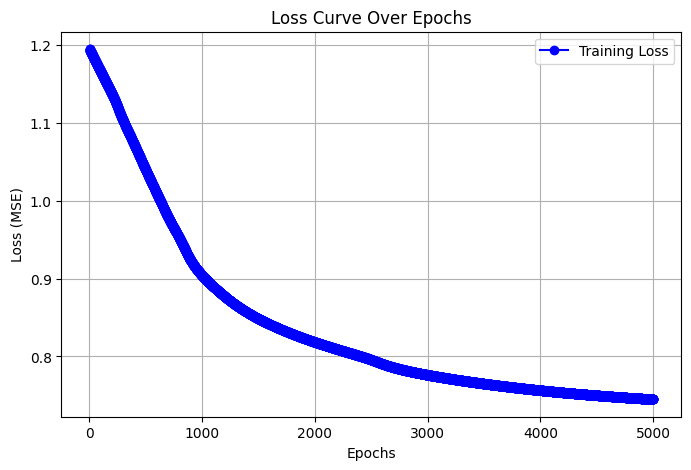

In [24]:
# Plot the loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), loss_values, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Loss Curve Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [27]:
# Check symmetry
is_symmetric = (cosine_sim_matrix == cosine_sim_matrix.T).all().all()
print(f"🔄 Symmetry preserved? {is_symmetric}")



🔄 Symmetry preserved? True


In [29]:
# Print the first few rows of the genetic distances matrix
print(" Genetic Distance Matrix (Preview):")
print(cosine_sim_matrix.head())

 Genetic Distance Matrix (Preview):


AttributeError: 'Tensor' object has no attribute 'head'

In [30]:
from scipy.stats import spearmanr, pearsonr

In [32]:
# Convert to NumPy arrays
cosine_sim_numpy = cosine_sim_matrix.cpu().detach().numpy()
genetic_distances_numpy = genetic_distances_tensor_as_cosine.cpu().detach().numpy()

# Create a DataFrame with family names as row and column labels
cosine_sim_df = pd.DataFrame(cosine_sim_numpy, index=common_families, columns=common_families)
genetic_df=    pd.DataFrame(genetic_distances_numpy, index=common_families, columns=common_families)
# Display the DataFrame
print("🔍 Cosine Similarity Matrix:")
print(cosine_sim_df.head())
print("🔍 Genetic Similarity Matrix:")
print(genetic_df.head()) # Show the first few rows

🔍 Cosine Similarity Matrix:
            Anomiidae   Arcidae  Arcticidae  Astartidae  Cardiidae  \
Anomiidae    1.000000  0.515301    0.519909    0.496225   0.571559   
Arcidae      0.515301  1.000000    0.517338    0.570418   0.572231   
Arcticidae   0.519909  0.517338    1.000000    0.785419   0.539784   
Astartidae   0.496225  0.570418    0.785419    1.000000   0.569613   
Cardiidae    0.571559  0.572231    0.539784    0.569613   1.000000   

            Carditidae  Chamidae  Cleidothaeridae  Corbulidae  Crassatellidae  \
Anomiidae     0.550923  0.525848         0.648566    0.531524        0.481293   
Arcidae       0.618219  0.499002         0.506384    0.448437        0.581890   
Arcticidae    0.468605  0.431611         0.673061    0.480989        0.746064   
Astartidae    0.475487  0.437333         0.562579    0.498377        0.930735   
Cardiidae     0.678164  0.551910         0.564198    0.647888        0.569189   

            ...  Teredinidae  Thraciidae  Thyasiridae  Trapezida

In [36]:
# Get indices for the upper triangle (excluding diagonal)
upper_tri_indices = np.triu_indices_from(cosine_sim_numpy, k=0)  # k=1 excludes diagonal

# Extract values from the upper triangle
cosine_sim_flat = cosine_sim_numpy[upper_tri_indices]
genetic_distances_flat = genetic_distances_numpy[upper_tri_indices]

# Compute Pearson and Spearman correlations
pearson_corr, pearson_pval = pearsonr(cosine_sim_flat, genetic_distances_flat)
spearman_corr, spearman_pval = spearmanr(cosine_sim_flat, genetic_distances_flat)

print(f"✅ Pearson Correlation: {pearson_corr:.4f} (p-value: {pearson_pval:.4e})")
print(f"✅ Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_pval:.4e})")

✅ Pearson Correlation: 0.4032 (p-value: 5.7419e-109)
✅ Spearman Correlation: 0.2358 (p-value: 2.3476e-36)


In [38]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.ndimage

labels_h = pd.read_excel("/mnt/data/labels..xlsx", index_col=0)

# Map families to their orders & filter to common families
family_to_order = labels_h.set_index("family")["order"]
filtered_family_to_order = family_to_order.loc[common_families]  # ✅ Reuse `common_families`

#  Sort families based on their taxonomic order
sorted_families = filtered_family_to_order.sort_values().index.unique().tolist()

#  Convert to NumPy arrays (reducing Pandas overhead)
genetic_distances_sorted = genetic_df.loc[sorted_families, sorted_families]
cosine_sim_df_sorted = cosine_sim_df.loc[sorted_families, sorted_families]


# Print the shapes of the sorted distance matrices
print(f"Shape of genetic_distances_sorted: {genetic_distances_sorted.shape}")
print(f"Shape of visual_distances_sorted: {cosine_sim_df_sorted.shape}")

Shape of genetic_distances_sorted: (74, 74)
Shape of visual_distances_sorted: (74, 74)


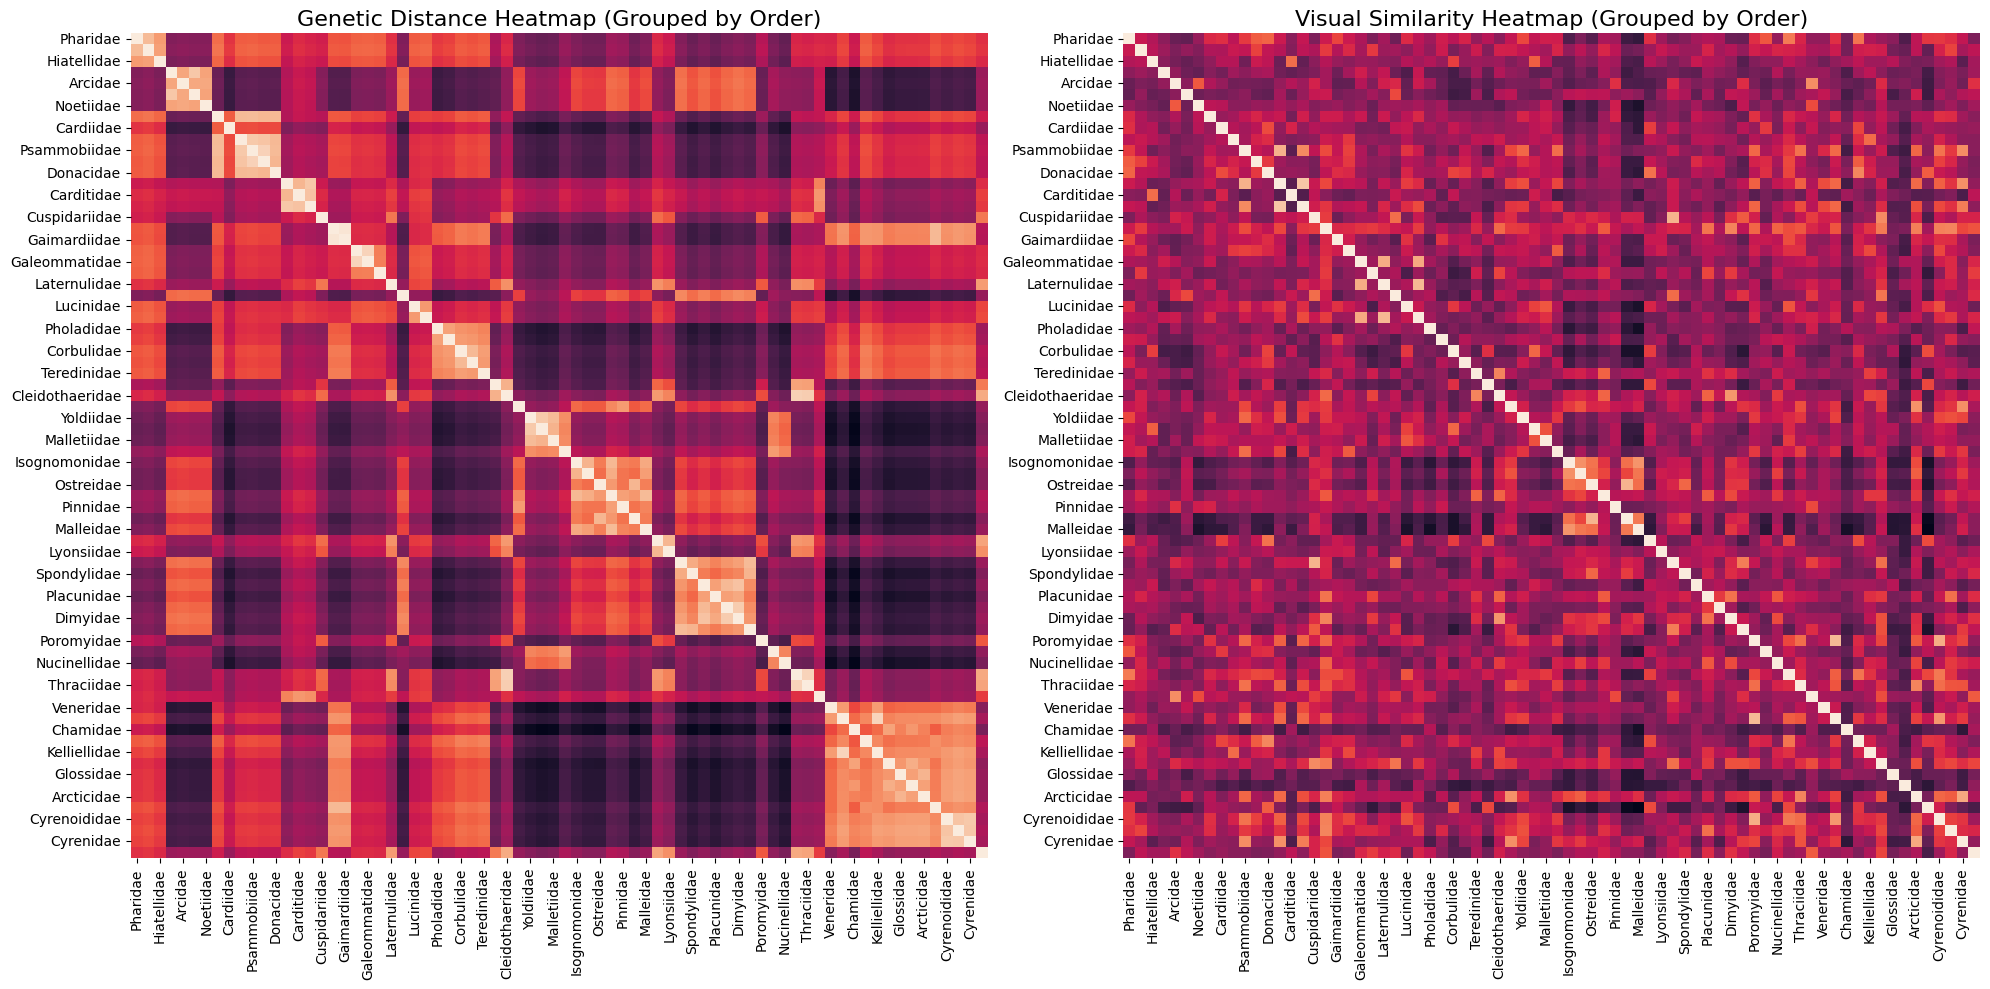

In [39]:
# Set up figure
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot Genetic Distance Heatmap (with optimized settings)
sns.heatmap(genetic_distances_sorted, cmap="rocket", ax=axes[0], cbar=False)
axes[0].set_title("Genetic Distance Heatmap (Grouped by Order)", fontsize=16)

# Plot Visual Similarity Heatmap
sns.heatmap(cosine_sim_df_sorted, cmap="rocket", ax=axes[1], cbar=False)
axes[1].set_title("Visual Similarity Heatmap (Grouped by Order)", fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Convert DataFrames to NumPy arrays (reducing overhead)
genetic_distances_np = genetic_distances_sorted.to_numpy(dtype=np.float32)
visual_distances_np = visual_distances_sorted.to_numpy(dtype=np.float32)

In [ ]:
# Step 1: Create a label mapping
unique_families = sorted(set([family for _, family in tensor_dataset]))  # Get unique labels
family_to_index = {family: idx for idx, family in enumerate(unique_families)}  # Map to index

# Print mapping for verification
print("Label Mapping (String to Index):", family_to_index)

# Step 2: Convert dataset labels to indices
indexed_dataset = [(image_tensor, family_to_index[family]) for image_tensor, family in tensor_dataset]

# Verify transformation
print(f"Original Label: {tensor_dataset[0][1]} -> Indexed Label: {indexed_dataset[0][1]}")


Label Mapping (String to Index): {'Anomiidae': 0, 'Arcidae': 1, 'Arcticidae': 2, 'Astartidae': 3, 'Cardiidae': 4, 'Carditidae': 5, 'Chamidae': 6, 'Cleidothaeridae': 7, 'Corbulidae': 8, 'Crassatellidae': 9, 'Cuspidariidae': 10, 'Cyamiidae': 11, 'Cyrenidae': 12, 'Cyrenoididae': 13, 'Dimyidae': 14, 'Donacidae': 15, 'Dreissenidae': 16, 'Gaimardiidae': 17, 'Galeommatidae': 18, 'Gastrochaenidae': 19, 'Glauconomidae': 20, 'Glossidae': 21, 'Glycymerididae': 22, 'Gryphaeidae': 23, 'Hemidonacidae': 24, 'Hiatellidae': 25, 'Isognomonidae': 26, 'Kelliellidae': 27, 'Lasaeidae': 28, 'Laternulidae': 29, 'Limidae': 30, 'Limopsidae': 31, 'Lucinidae': 32, 'Lyonsiidae': 33, 'Mactridae': 34, 'Malleidae': 35, 'Malletiidae': 36, 'Myidae': 37, 'Myochamidae': 38, 'Mytilidae': 39, 'Noetiidae': 40, 'Nucinellidae': 41, 'Nuculanidae': 42, 'Nuculidae': 43, 'Ostreidae': 44, 'Pandoridae': 45, 'Pectinidae': 46, 'Periplomatidae': 47, 'Pharidae': 48, 'Pholadidae': 49, 'Pinnidae': 50, 'Placunidae': 51, 'Plicatulidae': 52